# Model Evaluation

This notebook is for running and documenting experiments

## latentFairClassifier Evaluation

A classifier based on the model described in the paper 
*Group Fairness by Probabilistic Modeling with Latent Fair Decisions* has been 
successfully implemented and trained on the adult dataset. It is time to 
evaluate the model in terms of fairness as well as traditional metrics.

### Import

In [26]:
import pandas as pd
import sys
import os
from sklearn.metrics import roc_curve
pd.set_option('display.float_format', lambda x: '%.5f' % x)

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from forseti.datproc import translate_categorical, extract_sensitive
from forseti.metrics import plot_confusion_matrix, parity_score, fairness_report

### Load Dataset and Predictions 

In [27]:
tmp = pd.read_csv('data/adult.csv')
data, codes = translate_categorical(tmp.copy(deep=True))
sensitive_attributes = ['race', 'gender']

test = data[30000:]

sensitive, features = extract_sensitive(test, sensitive_attributes) 
y = features['income']
X = features.drop('income', axis=1)

y_pred_fair = pd.read_csv('results/y_pred_label_fair.csv', index_col=0)
y_pred_income = pd.read_csv('results/y_pred_label_income.csv', index_col=0)
y_pred_probability = pd.read_csv('results/y_pred.csv', index_col=0)

### Score metric for demographic parity

Demographic parity is defined as

$$
P(\hat{Y} | S = 0) = P(\hat{Y} | S = 1)
$$

Where $\hat{Y}$ is the predictor and $S$ is the sensitive attribute.

This can be generalised to a multiclass case with $K$ classes.

$$
P(\hat{Y} | S_i) = P(\hat{Y} | S_j) \qquad i, j \in \{0, \dots, K-1\}
$$

We want to condense this to a single metric between $0$ and $1$. I.e, when we 
have likelihood for the different classes of a sensitive attribute in a list of 
probabilities $L$ like so

$$
L =\{ P(\hat{Y} | S=0), \dots, P(\hat{Y} | S=K-1) \}
$$

We would want a score of 1 if that list has probabilities like

$$
L_0 = \{ 0.333, 0.333, 0.333\}
$$

and a score of 0 for

$$
L_1 = \{ 1, 0, 0\}
$$

and for that, we have worked out the following funsction $f$

$$
    f = \frac{\text{geometric mean}(L)}{\text{mean}(L)}
$$

and the example of which is shown below.

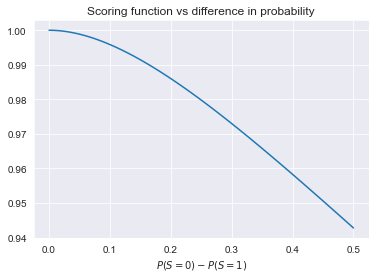

In [28]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 0.5, 100)
scores = []

for prob in x:
    scorelist = [0.5 + prob, 0.5]
    scores.append(parity_score(scorelist))

plt.plot(x, scores);
plt.title('Scoring function vs difference in probability');
plt.xlabel('$P(S=0) - P(S=1)$');

In [29]:
fairnessDF = pd.DataFrame()

fairnessDF = fairnessDF.append(fairness_report(y, y_pred_fair, sensitive, 'FairBN'), ignore_index=True)
fairnessDF = fairnessDF.append(fairness_report(y, y_pred_income, sensitive, 'IncomeBN'), ignore_index=True)
fairnessDF = fairnessDF.append(fairness_report(y, y, sensitive, 'Dataset'), ignore_index=True)
fairnessDF

C:\Users\bcwei\AppData\Local\Temp/ipykernel_20268/3025736538.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fairnessDF = fairnessDF.append(fairness_report(y, y_pred_fair, sensitive, 'FairBN'), ignore_index=True)
C:\Users\bcwei\AppData\Local\Temp/ipykernel_20268/3025736538.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fairnessDF = fairnessDF.append(fairness_report(y, y_pred_income, sensitive, 'IncomeBN'), ignore_index=True)
C:\Users\bcwei\AppData\Local\Temp/ipykernel_20268/3025736538.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fairnessDF = fairnessDF.append(fairness_report(y, y, sensitive, 'Dataset'), ignore_index=True)


,Accuracy,Balanced Accuracy,F1 Score,Specificity,Positive Parity Score race,Positive Parity Score gender,Model
0,0.82443,0.75570,0.63171,0.88883,0.96196,0.99208,FairBN
1,0.83447,0.72144,0.59488,0.94036,0.74336,0.00000,IncomeBN
2,1.00000,1.00000,1.00000,1.00000,0.91493,0.87966,Dataset


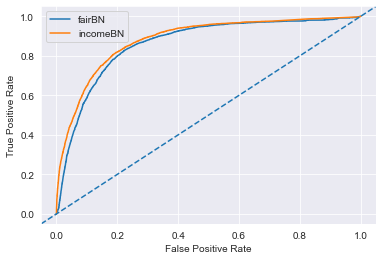

In [30]:
fpr_fair, tpr_fair, threshold = roc_curve(y,  y_pred_probability['fair_0'])
fpr_income, tpr_income, _ = roc_curve(y,  y_pred_probability['income_1'])

#create ROC curve
plt.plot(fpr_fair, tpr_fair, label='fairBN')
plt.plot(fpr_income, tpr_income, label='incomeBN')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axline((1, 1), slope=1, ls="--")
plt.legend()
plt.savefig('figures/baseline_roc.png', dpi=200)
plt.show()